In [32]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import os

import matplotlib.pyplot as plt

sys.path.append("src.py")
from src import Utils

# get phospho data
ph_data = pd.read_pickle("./data/datasets/islets_PTP_dataset.pkl")
ph_sample_metadata = pd.read_pickle("./data/datasets/islets_PTP_sample_metadata.pkl")
ph_feature_metadata = pd.read_pickle("./data/datasets/islets_PTP_feature_metadata.pkl")

# parse position out of main identifier
ph_feature_metadata['aa_position'] = ph_feature_metadata.index.str.split('_').str[1]
ph_feature_metadata['position'] = ph_feature_metadata['aa_position'].replace('^.','',regex = True).astype(int)
ph_feature_metadata['uniprot_position'] = ph_feature_metadata['PG.UniProtIds'] + '_' + ph_feature_metadata['position'].astype(str)
ph_feature_metadata['Gene'] = ph_feature_metadata.index.str.split('_').str[0]

# functional annotation scores from [Ochoa, David, et al. "The functional landscape of the human phosphoproteome." Nature biotechnology 38.3 (2020): 365-373.]
fscores = pd.read_excel("./41587_2019_344_MOESM5_ESM.xlsx")
fscores['uniprot_position'] = fscores['uniprot'] + '_' + fscores['position'].astype(str)

# add functional scores to data
ph_feature_metadata = ph_feature_metadata.merge(fscores[['uniprot_position', 'functional_score']], on='uniprot_position', how='left')
ph_feature_metadata.set_index('PTM_collapse_key', inplace=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
fscores

,uniprot,position,functional_score,uniprot_position
0,A0A075B6Q4,24,0.149257,A0A075B6Q4_24
1,A0A075B6Q4,68,0.119811,A0A075B6Q4_68
2,A0A075B6T3,24,0.477724,A0A075B6T3_24
3,A0A075B759,68,0.087843,A0A075B759_68
4,A0A087WTJ2,8,0.168085,A0A087WTJ2_8
...,...,...,...,...
116253,Q9Y6M1,40,0.480261,Q9Y6M1_40
116254,Q9Y6N7,1038,0.636282,Q9Y6N7_1038
116255,Q9Y6N7,1476,0.405682,Q9Y6N7_1476
116256,Q9Y6Q9,574,0.328472,Q9Y6Q9_574


### [F10] Phosphoproteomics 

Visualize phosphoproteomics differential results alongside functional score annotations


In [6]:
# ttest comparison between cell types (control only) for phospho data

ph_diff_exp = {}

# alpha vs. delta:
mask = ph_sample_metadata['sample'].isin(['alpha', 'delta'])
ph_diff_exp['alpha_over_delta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')

# beta vs. delta:
mask = ph_sample_metadata['sample'].isin(['beta', 'delta'])
ph_diff_exp['beta_over_delta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')

# alpha vs. beta:
mask = ph_sample_metadata['sample'].isin(['alpha', 'beta'])
ph_diff_exp['alpha_over_beta'] = Utils.group_ratios_ttest_ind(ph_data[mask], ph_sample_metadata[mask], between = 'sample').join(ph_feature_metadata, how = 'left')


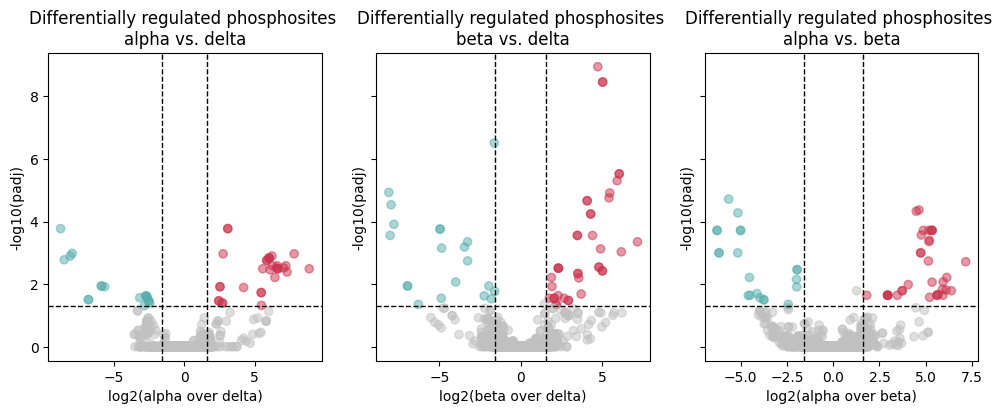

In [13]:
import numpy as np
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey = True)

# visualize and extract differentially regulated proteins
differentially_regulated_sites = {}
for i, (comparison, diff_exp) in enumerate(ph_diff_exp.items()):

    P_LIM = 0.05
    X_LIM = 3
    LINEWIDTH = 1

    x_col = f'delta_{comparison}'
    y_col = f'padj_{comparison}'

    diff_exp[f'neg_log10_{y_col}'] = -np.log10(diff_exp[y_col])

    diff_exp['regulated'] = 'not regulated'
    diff_exp.loc[((diff_exp[x_col] > np.log2(X_LIM)) & (diff_exp[y_col] < P_LIM)), 'regulated'] = 'upregulated'
    diff_exp.loc[((diff_exp[x_col] < -np.log2(X_LIM)) & (diff_exp[y_col] < P_LIM)), 'regulated'] = 'downregulated'

    colormap = {
        'not regulated': '#C0C0C0',
        'upregulated': '#cb334d',
        'downregulated': '#54aead',
        'selected' : '#3a7eb8',
    }

    differentially_regulated_sites[comparison] = diff_exp[diff_exp['regulated'].isin(['upregulated', 'downregulated'])].copy()

    # plot volcano plot
    ax = axs[i]

    reg_colors = diff_exp['regulated'].map(colormap)
    ax.scatter(diff_exp[x_col], diff_exp[f'neg_log10_{y_col}'], c=reg_colors, alpha=0.5)
    
    ax.axhline(y=-np.log10(P_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)
    ax.axvline(x=np.log2(X_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)
    ax.axvline(x=-np.log2(X_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)

    ax.set_xlabel(f'log2({" ".join(comparison.split("_"))})')
    ax.set_ylabel('-log10(padj)')

    ax.set_title(f'Differentially regulated phosphosites \n{comparison.replace("_over_", " vs. ")}')

In [14]:
# find orthologs
for comparison, diff_exp in differentially_regulated_sites.items():
    print(diff_exp['PG.UniProtIds'].unique())

['O35085' 'P16014' 'Q7TS73' 'Q9D1Y9' 'Q5SWY7' 'P55095' 'Q99MA9' 'P60041']
['Q8K0M7' 'Q9CQV4' 'Q5SWY7' 'Q8C419' 'B2RXC2' 'P57016' 'Q8CF90' 'Q99MA9'
 'P97926' 'P48437' 'P35822' 'Q9EPS2' 'Q80U57' 'Q8VCX2' 'Q04692' 'Q9JJY3'
 'P60041' 'Q9WUH1' 'Q01320']
['O35085' 'P55095' 'Q9DAS9' 'Q8C419' 'B2RXC2' 'P57016' 'A2AQW0' 'Q9CQ20'
 'Q99MA9' 'P97926' 'E9PZ87' 'P63239' 'P35822' 'Q80U57' 'P14246']


mouse2human [Human gene stable ID] --> map(human_ensembl2uniprot) to get mouse2human [UniProtID]
phosphosite feature metadata [Gene] --> mouse2human [Gene name] [UniProtID] --> fscores [uniprot]

In [74]:
# get Mouse to Human gene mapping from the ENSEMBL databaset:
# http://www.ensembl.org/biomart/martview/775974b699d308980b35a596a385b751?VIRTUALSCHEMANAME=default&ATTRIBUTES=mmusculus_gene_ensembl.default.homologs.ensembl_gene_id|mmusculus_gene_ensembl.default.homologs.ensembl_gene_id_version|mmusculus_gene_ensembl.default.homologs.ensembl_transcript_id|mmusculus_gene_ensembl.default.homologs.ensembl_transcript_id_version|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_ensembl_gene|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_associated_gene_name|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_perc_id|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_ensembl_peptide|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_orthology_type|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_orthology_confidence|mmusculus_gene_ensembl.default.homologs.external_gene_name&FILTERS=&VISIBLEPANEL=resultspanel
mouse2human = pd.read_csv("./mouse2human_ortholog_mapping.txt", header = 0).dropna(subset=["Human gene name"])

# Handle mapping of ENSEMBL to uniprot IDs using bioMart. Prefer static version of mapping dict due to possible API changes
mapping_dict_name = "2025-04-30_10_37_56_hsapiens_ref_dict.pkl"
if not os.path.exists("2025-04-30_10_37_56_hsapiens_ref_dict.pkl"):
    mapping_dict_name = f"./{pd.Timestamp.now().strftime('%Y-%m-%d_%H_%M_%S')}_hsapiens_ref_dict.pkl"
    hsapiens_ref_dict = Utils.map_ensembl_to_uniprot('hsapiens', True)
    pd.DataFrame.from_dict(hsapiens_ref_dict, orient = 'index', columns = ['uniprot_id']).to_pickle(mapping_dict_name)
hsapiens_ref_dict = pd.read_pickle(mapping_dict_name)['uniprot_id'].to_dict()

def add_uniprot_ids_to_mouse2human(
    mouse2human: pd.DataFrame,
    hsapiens_ref_dict: dict,
):
    # Get mouse2human['human_UniProtID'] by mapping mouse2human['Human gene stable ID'] to human_ensembl2uniprot
    mouse2human['human_UniProtID'] = mouse2human['Human gene stable ID'].map(hsapiens_ref_dict)
    return mouse2human

def human_IDs_to_feature_metadata(
    functional_scores_df: pd.DataFrame,
    mouse2human: pd.DataFrame,
    phospho_feature_metadata: pd.DataFrame,
):

    # Transfer the human_UniProtID from mouse2human to the phospho_feature_metadata by mapping the mouse gene columns to each other
    phospho_feature_metadata = phospho_feature_metadata.merge(mouse2human[['Gene name', 'human_UniProtID']], left_on = "Gene", right_on = "Gene name", how = 'left')

    return phospho_feature_metadata

mouse2human = add_uniprot_ids_to_mouse2human(mouse2human, hsapiens_ref_dict)
phfm = human_IDs_to_feature_metadata(mouse2human = mouse2human, functional_scores_df = fscores, phospho_feature_metadata = ph_feature_metadata)

In [75]:
mouse2human

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Human gene stable ID,Human gene name,%id. target Human gene identical to query gene,Human protein or transcript stable ID,Human homology type,"Human orthology confidence [0 low, 1 high]",Gene name,human_UniProtID
5,ENSMUSG00000064341,ENSMUSG00000064341.1,ENSMUST00000082392,ENSMUST00000082392.1,ENSG00000198888,MT-ND1,77.0440,ENSP00000354687,ortholog_one2one,1.0,mt-Nd1,P03886
9,ENSMUSG00000064345,ENSMUSG00000064345.1,ENSMUST00000082396,ENSMUST00000082396.1,ENSG00000198763,MT-ND2,57.3913,ENSP00000355046,ortholog_one2one,1.0,mt-Nd2,P03891
15,ENSMUSG00000064351,ENSMUSG00000064351.1,ENSMUST00000082402,ENSMUST00000082402.1,ENSG00000198804,MT-CO1,90.6615,ENSP00000354499,ortholog_one2one,1.0,mt-Co1,P00395
18,ENSMUSG00000064354,ENSMUSG00000064354.1,ENSMUST00000082405,ENSMUST00000082405.1,ENSG00000198712,MT-CO2,71.3656,ENSP00000354876,ortholog_one2one,1.0,mt-Co2,P00403
20,ENSMUSG00000064356,ENSMUSG00000064356.1,ENSMUST00000082407,ENSMUST00000082407.1,ENSG00000228253,MT-ATP8,46.2687,ENSP00000355265,ortholog_one2one,0.0,mt-Atp8,P03928
...,...,...,...,...,...,...,...,...,...,...,...,...
285960,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000054591,ENSMUST00000054591.10,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1,Q8IYQ7
285961,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000102952,ENSMUST00000102952.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1,Q8IYQ7
285962,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000138965,ENSMUST00000138965.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1,Q8IYQ7
285963,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000138914,ENSMUST00000138914.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1,Q8IYQ7


In [62]:
mouse2human['human_UniProtID'].unique().tolist()

['P03886',
 'P03891',
 'P00395',
 'P00403',
 'P03928',
 'P00846',
 'P00414',
 'P03897',
 'P03901',
 'P03905',
 'P03915',
 'P03923',
 'P00156',
 'O60813',
 'A6NGN4',
 'A0A1B0GU46',
 'Q5VT98',
 'P0DUQ2',
 'Q5TYX0',
 'O95522',
 'O60811',
 'A0A1W2PPB9',
 'Q5VTA0',
 'Q5VWM3',
 'Q5VXH5',
 'O60810',
 'H0Y7S4',
 'A3QJZ7',
 'O95521',
 'Q5SWL8',
 'Q5VXH4',
 'Q5SWL7',
 'A0A0G2JMD5',
 'Q5VWM4',
 'O60809',
 'A0A8V8TN67',
 'H7C4B4',
 'Q8IZU3',
 'A6NDE4',
 'Q15415',
 'P0DJD3',
 'A6NEQ0',
 'P0C7P1',
 'J3KQ82',
 'M0QXN3',
 'Q9H707',
 'E7ETH6',
 'M0R336',
 'J3KQR4',
 'M0R0A3',
 'P52741',
 'M0R2X0',
 'Q13106',
 'Q68DY9',
 'Q6PK81',
 'E7EQD3',
 'K7EN01',
 'Q8N587',
 'F8WEZ9',
 'Q8N9Z0',
 'E5RJT6',
 'M0R2J6',
 'K7EMU0',
 'Q96EG3',
 'S4R3B8',
 'H7BZF9',
 'O14607',
 'C9J081',
 'O00507',
 'A0A8Q3WKH5',
 'A0A3B3IU63',
 'Q05066',
 'Q7L1S5',
 nan,
 'P19022',
 'A0A6Q8PHT7',
 'Q9Y6M4',
 'Q14574',
 'A0A0C4DGB8',
 'D6R9P9',
 'Q02487',
 'Q08554',
 'Q02413',
 'P49419',
 'Q86SJ6',
 'Q9H814',
 'Q6ZNM6',
 'P20700',
 'Q86

In [15]:
# ortholog mapping since this dataset is from M.musculus

from Bio import pairwise2
from Bio.Seq import Seq
from Bio import SeqIO
from biomart import BiomartServer



# try mapping the mouse UniProt IDs to human

# load human uniprot IDs and fasta

# load mouse uniprot IDs and fasta

/Users/vincenthbrennsteiner/miniconda3/envs/momi_310/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [33]:
mouse2human

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Human gene stable ID,Human gene name,%id. target Human gene identical to query gene,Human protein or transcript stable ID,Human homology type,"Human orthology confidence [0 low, 1 high]",Gene name,UniProtID
5,ENSMUSG00000064341,ENSMUSG00000064341.1,ENSMUST00000082392,ENSMUST00000082392.1,ENSG00000198888,MT-ND1,77.0440,ENSP00000354687,ortholog_one2one,1.0,mt-Nd1,P03886
9,ENSMUSG00000064345,ENSMUSG00000064345.1,ENSMUST00000082396,ENSMUST00000082396.1,ENSG00000198763,MT-ND2,57.3913,ENSP00000355046,ortholog_one2one,1.0,mt-Nd2,P03891
15,ENSMUSG00000064351,ENSMUSG00000064351.1,ENSMUST00000082402,ENSMUST00000082402.1,ENSG00000198804,MT-CO1,90.6615,ENSP00000354499,ortholog_one2one,1.0,mt-Co1,P00395
18,ENSMUSG00000064354,ENSMUSG00000064354.1,ENSMUST00000082405,ENSMUST00000082405.1,ENSG00000198712,MT-CO2,71.3656,ENSP00000354876,ortholog_one2one,1.0,mt-Co2,P00403
20,ENSMUSG00000064356,ENSMUSG00000064356.1,ENSMUST00000082407,ENSMUST00000082407.1,ENSG00000228253,MT-ATP8,46.2687,ENSP00000355265,ortholog_one2one,0.0,mt-Atp8,P03928
...,...,...,...,...,...,...,...,...,...,...,...,...
285960,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000054591,ENSMUST00000054591.10,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1,Q8IYQ7
285961,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000102952,ENSMUST00000102952.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1,Q8IYQ7
285962,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000138965,ENSMUST00000138965.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1,Q8IYQ7
285963,ENSMUSG00000048550,ENSMUSG00000048550.18,ENSMUST00000138914,ENSMUST00000138914.8,ENSG00000185875,THNSL1,82.1954,ENSP00000365534,ortholog_one2one,1.0,Thnsl1,Q8IYQ7


In [25]:
hsapiens_ref_dict = Utils.map_ensembl_to_uniprot(organism = "hsapiens")
hsapiens_ref_dict

In [31]:
hsapiens_ref_dict

{'ENSG00000198888': 'P03886',
 'ENSG00000198763': 'P03891',
 'ENSG00000198804': 'P00395',
 'ENSG00000198712': 'P00403',
 'ENSG00000228253': 'P03928',
 'ENSG00000198899': 'P00846',
 'ENSG00000198938': 'P00414',
 'ENSG00000198840': 'P03897',
 'ENSG00000212907': 'P03901',
 'ENSG00000198886': 'P03905',
 'ENSG00000198786': 'P03915',
 'ENSG00000198695': 'P03923',
 'ENSG00000198727': 'P00156',
 'ENSG00000277400': 'Q8WZ33',
 'ENSG00000278817': 'X5D7D2',
 'ENSG00000268674': 'P0DMU3',
 'ENSG00000277475': 'A0AVG0',
 'ENSG00000275063': 'P0DP08',
 'ENSG00000278384': 'Q6ZW97',
 'ENSG00000288175': 'X6R8R1',
 'ENSG00000288157': 'P0DQD5',
 'ENSG00000288481': 'B3EWG5',
 'ENSG00000288499': 'Q8IXL6',
 'ENSG00000281934': 'O60813',
 'ENSG00000282175': 'O60812',
 'ENSG00000288297': 'Q19T08',
 'ENSG00000282817': 'O60811',
 'ENSG00000288274': 'A0A1B0GW64',
 'ENSG00000282584': 'O60810',
 'ENSG00000282663': 'O60809',
 'ENSG00000279195': 'Q5VXH5',
 'ENSG00000288243': 'A0A494C0T1',
 'ENSG00000282119': 'Q5VXH4',
 '

In [26]:
mouse2human['UniProtID'] = mouse2human['Human gene stable ID'].map(hsapiens_ref_dict)

In [21]:
ph_feature_metadata['Gene']

mouse2human['Gene name']

5          mt-Nd1
9          mt-Nd2
15         mt-Co1
18         mt-Co2
20        mt-Atp8
           ...   
285960     Thnsl1
285961     Thnsl1
285962     Thnsl1
285963     Thnsl1
285964     Thnsl1
Name: Gene name, Length: 104597, dtype: object